# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021

In [1]:
%load_ext nb_black
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

<IPython.core.display.Javascript object>

In [147]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 15
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR


<IPython.core.display.Javascript object>

In [46]:
# Sample the distribution
x_a = stats.norm.rvs(size=1000, loc=0, scale=1,)
x_b = stats.norm.rvs(size=100, loc=2, scale=1,)
x_hierarchy = np.append(x_a, x_b)


# Fitting the distribution
mu_fit, sigma_fit = stats.norm.fit(data=x_hierarchy)
print(mu_fit, sigma_fit)

0.14574929476660042 1.150353155698961


<IPython.core.display.Javascript object>

In [37]:
index_a = np.zeros(len(x_a), dtype=np.int8)
index_b = np.ones(len(x_b), dtype=np.int8)
index = np.append(index_a, index_b)


<IPython.core.display.Javascript object>

In [81]:
with pm.Model() as mod:
    # Prior
    mu = pm.Normal(
        name="mu",
        mu=0,
        sigma=10,
        shape=2,
    )
    # Likelihood
    obs = pm.Normal(
        name="x",
        observed=x_hierarchy,
        mu=mu[index],
        sigma=1,
    )
    # Posterior
    trace_ind = pm.sample(draws=1000)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
INFO:pymc3:NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


<IPython.core.display.Javascript object>

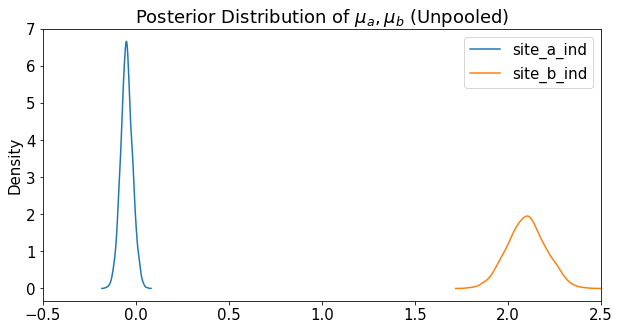

<IPython.core.display.Javascript object>

In [138]:
mu_ind = trace_ind.get_values("mu")

df_ind = pd.DataFrame(mu_ind, columns=["site_a_ind", "site_b_ind"]).assign(
    **{"type": "unpooled"}
)

sns.kdeplot(data=df_ind, shade=False)
plt.xlim([-0.5, 2.5])
plt.title("Posterior Distribution of $\mu_a, \mu_b$ (Unpooled)")
plt.show()

In [86]:
with pm.Model() as hierarchical_mod:
    # Set a global prior for the parameters     
    mu_glob = pm.Normal(
        name="mu_glob",
        mu=1,
        sigma=0.1,
    )
    
    # Prior
    mu = pm.Normal(
        name="mu",
        mu=mu_glob,
        sigma=0.1,
        shape=2,
    )
    # Likelihood
    obs = pm.Normal(
        name="x",
        observed=x_hierarchy,
        mu=mu[index],
        sigma=1,
    )
    trace_prior = pm.sample_prior_predictive(samples=1000)
    # Posterior
    trace = pm.sample(draws=1000)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, mu_glob]
INFO:pymc3:NUTS: [mu, mu_glob]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

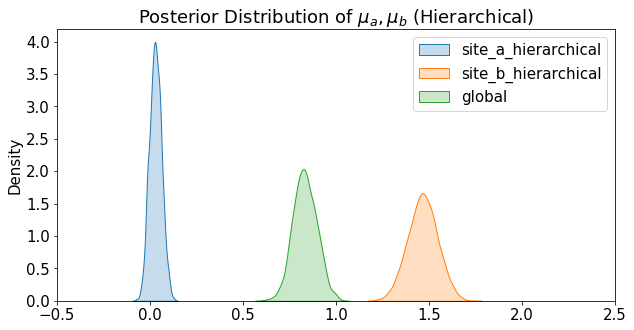

<IPython.core.display.Javascript object>

In [124]:
df_hierarchy = pd.DataFrame(
    trace.get_values("mu"), columns=["site_a_hierarchical", "site_b_hierarchical"]
).assign(**{"global": trace.get_values("mu_glob"), "type": "hierarchical"})

sns.kdeplot(data=df_hierarchy, shade=True)
plt.title("Posterior Distribution of $\mu_a, \mu_b$ (Hierarchical)")

plt.xlim([-0.5, 2.5])
plt.show()

In [125]:
df_all = pd.concat([df_hierarchy, df_ind,], axis="columns",)
df_all

,site_a_hierarchical,site_b_hierarchical,global,type,site_a_ind,site_b_ind,type
0,0.048652,1.461399,0.757260,hierarchical,-0.007478,1.997038,unpooled
1,0.040987,1.508102,0.918015,hierarchical,-0.017545,2.307043,unpooled
2,-0.003901,1.456182,0.763974,hierarchical,-0.050010,2.112722,unpooled
3,0.082931,1.498291,0.827782,hierarchical,-0.099369,2.184626,unpooled
4,0.008700,1.393389,0.834297,hierarchical,-0.088601,2.160077,unpooled
...,...,...,...,...,...,...,...
1995,0.061035,1.468600,0.870517,hierarchical,-0.092125,2.160452,unpooled
1996,0.054748,1.611486,0.914763,hierarchical,-0.010244,2.113272,unpooled
1997,0.013128,1.398224,0.812093,hierarchical,-0.065307,2.066172,unpooled
1998,0.016318,1.377101,0.924944,hierarchical,-0.085201,2.049875,unpooled


<IPython.core.display.Javascript object>

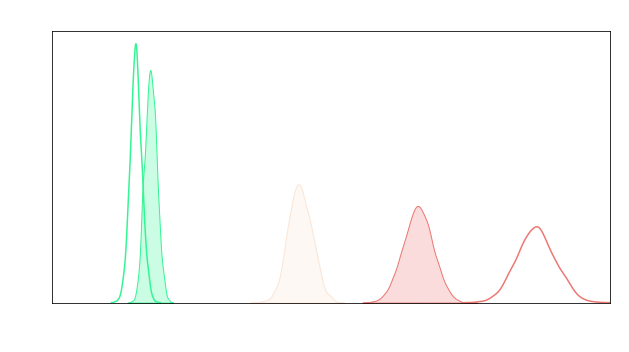

<IPython.core.display.Javascript object>

In [151]:
sns.kdeplot(
    data=df_all["site_a_ind"], color="#33F594", shade=False, label="site_a_unpooled"
)
sns.kdeplot(
    data=df_all["site_a_hierarchical"],
    color="#33F594",
    shade=True,
    label="site_a_hierarchical",
)

sns.kdeplot(
    data=df_all["site_b_ind"], shade=False, color="#EB7772", label="site_b_unpooled"
)
sns.kdeplot(
    data=df_all["site_b_hierarchical"],
    shade=True,
    color="#EB7772",
    label="site_b_hierarchical",
)

sns.kdeplot(
    data=df_all["global"], shade=True, color="#FBE5D6", label="global",
)


plt.title("Posterior Distribution of $\mu_a, \mu_b$, $\mu_{glob}$")

plt.xlim([-0.5, 2.5])
# plt.legend()
# plt.show()
plt.savefig('foo.png', bbox_inches='tight', transparent=True)
